# _P(s)_ on binned and balanced contact matrices, a.k.a. "expected"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mirnylib.plotting
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler

In [2]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [56]:
conditions = ['WT', 'T', 'dN']
binsize = 100000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [54]:
from cooltools.expected import diagsum, blocksum_pairwise
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]


cis_exp = {}
trs_exp = {}

with mp.Pool(8) as pool:
    for cond in conditions:
        
        print(cond, 'cis')
        tables = diagsum(
            clrs[cond], 
            supports, 
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2'],
            },
            chunksize=10000000,
            ignore_diags=2, 
            map=pool.map)
        
        cis_exp[cond] = pd.concat(
            [tables[support] for support in supports], 
            keys=[support[0] for support in supports], 
            names=['chrom'])
        cis_exp[cond]['balanced.avg'] = cis_exp[cond]['balanced.sum'] / cis_exp[cond]['n_valid']
        
        cis_exp[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv', sep='\t')
        
        print(cond, 'trans')
        records = blocksum_pairwise(
            clrs[cond],                
            supports, 
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2'],
            },
            chunksize=10000000,
            map=pool.map)
        
        trs_exp[cond] = pd.DataFrame(
            [{'chrom1': s1[0], 'chrom2': s2[0], **rec} for (s1, s2), rec in records.items()], 
            columns=['chrom1', 'chrom2', 'n_valid', 'count.sum', 'balanced.sum'])
        
        trs_exp[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.expected.trans.tsv', sep='\t', index=False)

WT cis
WT trans
T cis
T trans
dN cis
dN trans


In [12]:
cis_exp['WT'].head()

n_valid  count.sum  balanced.sum  balanced.avg
chrom diag                                                
chr1  0        1914        NaN           NaN           NaN
      1        1907        NaN           NaN           NaN
      2        1903   173893.0     48.647724      0.025564
      3        1900   116393.0     32.582628      0.017149
      4        1897    87032.0     24.416348      0.012871

In [13]:
trs_exp['WT'].head()

,chrom1,chrom2,n_valid,count.sum,balanced.sum
0,chr1,chr2,3580746,147487.0,40.245619
1,chr1,chr3,3144876,127399.0,36.505282
2,chr1,chr4,3065416,123441.0,34.687840
3,chr1,chr5,3004342,112261.0,31.695929
4,chr1,chr6,2947618,119073.0,33.525632


In [57]:
stats = {}
for cond in conditions:    
    n_cis = int(cis_exp[cond]['count.sum'].sum())
    n_trs = int(trs_exp[cond]['count.sum'].sum())
    stats[long_names[cond]] = {
        'cis': n_cis,
        'trans': n_trs,
        'total': n_cis + n_trs,
        'cis:trans': n_cis / n_trs,
        'cis:total': n_cis / (n_cis + n_trs)
    }
pd.DataFrame.from_dict(stats, orient='index')

,cis,trans,total,cis:trans,cis:total
NipblKO,46278739,29372427,75651166,1.575584,0.611739
TAM,36593527,19690322,56283849,1.858452,0.650160
Wildtype,28797530,14230469,43027999,2.023653,0.669274


In [58]:
sums = {}
n_valid = {}
scalings = {}
for cond in conditions:
    grouped = cis_exp[cond].groupby('diag')
    n_valid[cond] = grouped['n_valid'].sum().values
    sums[cond] = grouped['balanced.sum'].sum().values
    scalings[cond] = (sums[cond] / n_valid[cond])

/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [59]:
from cooltools.lib import numutils

def coarsen_geometric(sums, counts, n_bins=100):
    dbins = numutils.logbins(1, len(sums), N=n_bins)
    spans = list(zip(dbins[:-1], dbins[1:]))
    s = np.array([np.nansum(sums[lo:hi]) for lo, hi in spans])
    n = np.array([np.nansum(counts[lo:hi]) for lo, hi in spans])
    return dbins, s / n

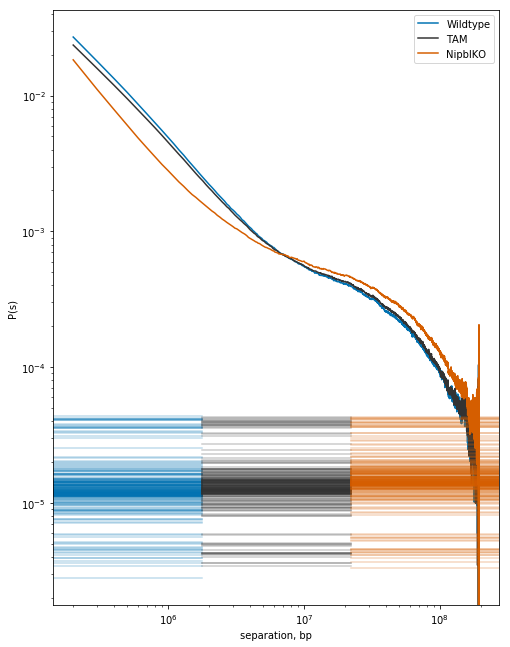

In [60]:
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[10, 2])
plt.figure(figsize=(8, 15))

ax1 = plt.subplot(gs[0])
for i, cond in enumerate(conditions):
    
    ref_point = 200000 // binsize
    norm = 1 #scalings[cond][ref_point]
    
    # cis P(s)
    x = np.arange(0, len(scalings[cond]) * binsize, binsize)
    y = scalings[cond] / norm
#     x, y = coarsen_geometric(sums[cond], n_valid[cond], 100)
#     x *= binsize
#     x = x[:-1]
    
    plt.plot(x, y, 
             color=colors[cond],
             label=long_names[cond])
    
    # average trans levels
    for _, row in trs_exp[cond].iterrows():
        plt.axhline(
            (row['balanced.sum']/row['n_valid']) / norm, 
            xmin=i/len(conditions),
            xmax=(i+1)/len(conditions),
            c=colors[cond], 
            alpha=0.25)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('P(s)')
plt.xlabel('separation, bp')
plt.legend()
plt.gca().set_aspect(1)
xlim = plt.xlim()

# plt.subplot(gs[1])
# for cond in conditions:
#     seps = np.arange(0, len(scalings[cond]) * binsize, binsize) #np.sqrt(dbins[:-1] * dbins[1:])
#     #cfs = scalings[cond] / scalings[cond][ref_point]
    
#     x, y = coarsen_geometric(sums[cond], n_valid[cond], 100)
#     x *= binsize
#     x = x[:-1]
#     dydx = np.diff(np.log10(y))/ np.diff(np.log10(x))
#     plt.plot(x[:-1], dydx, 
#              color=colors[cond], 
#              label=cond,
#              ls='--' if cond.endswith('2') else '-')
# plt.xscale('log')
# plt.ylabel('derivative')
# plt.xlabel(r'genomic separation $s$, bp')
# #plt.legend(ncol=2)
# plt.xlim(1e5, 1e6)
# plt.ylim(-1.5, 0)